In [144]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [145]:
import exchange_calendars as ecals 
import exchange_calendars as ecals
import pandas as pd
import pytz
XKRX = ecals.get_calendar("XKRX") # 한국 코드 

print(len(XKRX.sessions_in_range(pd.Timestamp("2021-01-01", tz=pytz.UTC), pd.Timestamp("2021-07-31", tz=pytz.UTC)))+1)

146


In [146]:
cus = pd.read_csv("cus_info.csv")
iem = pd.read_csv("iem_info_20210902.csv")
hist = pd.read_csv("stk_bnc_hist.csv")
train = pd.read_csv("stk_hld_train.csv")
test = pd.read_csv("stk_hld_test.csv")
submission = pd.read_csv("sample_submission.csv")

In [147]:
train['byn_dt'] = train['byn_dt'].astype(str)


In [148]:
def delete3(x): #수정 중


    ppp1 = len(XKRX.sessions_in_range(pd.Timestamp(x['byn_dt'][0:4]+"-"+x['byn_dt'][4:6]+"-"+x['byn_dt'][6:8], tz=pytz.UTC), pd.Timestamp('2019-11-01', tz=pytz.UTC)))

    ppp2 = len(XKRX.sessions_in_range(pd.Timestamp(x['byn_dt'][0:4]+"-"+x['byn_dt'][4:6]+"-"+x['byn_dt'][6:8], tz=pytz.UTC), pd.Timestamp('2020-05-31', tz=pytz.UTC)))

    if ppp1 == 0:
        return '99'

    if ppp1 <= x['hold_d'] and x['hold_d']<= ppp2:
        return x['byn_dt']
    else:
        return '99'

def delete4(x): #수정 중


    ppp1 = len(XKRX.sessions_in_range(pd.Timestamp(x['byn_dt'][0:4]+"-"+x['byn_dt'][4:6]+"-"+x['byn_dt'][6:8], tz=pytz.UTC), pd.Timestamp('2020-06-01', tz=pytz.UTC)))

    if ppp1 == 0:
        return '99'

    if ppp1 <= x['hold_d']:
        return x['byn_dt']
    else:
        return '99'



In [149]:
train = pd.read_csv("stk_hld_train.csv")
train['byn_dt'] = train['byn_dt'].astype(str)
train_xx = train
train_xx['byn_dt'] = train_xx.apply(delete3, axis =1)

train = pd.read_csv("stk_hld_train.csv")
train['byn_dt'] = train['byn_dt'].astype(str)
val_xx = train
val_xx['byn_dt'] = val_xx.apply(delete4, axis =1)

tmp11 = train_xx[train_xx['byn_dt'] == '99'].index
train_xx = train_xx.drop(tmp11)
tmp22 = val_xx[val_xx['byn_dt'] == '99'].index
val_xx = val_xx.drop(tmp22)

In [150]:
def plus2(x): #수정 중

            
    w = int(x['byn_dt'][2:4])


    ppp1 = len(XKRX.sessions_in_range(pd.Timestamp(x['byn_dt'][0:4]+"-"+x['byn_dt'][4:6]+"-"+x['byn_dt'][6:8], tz=pytz.UTC), pd.Timestamp('2019-11-01', tz=pytz.UTC)))
      
    if ppp1 == 0:
        print("발생2")
    return ppp1

def plus3(x): #수정 중

            
    w = int(x['byn_dt'][2:4])


    ppp1 = len(XKRX.sessions_in_range(pd.Timestamp(x['byn_dt'][0:4]+"-"+x['byn_dt'][4:6]+"-"+x['byn_dt'][6:8], tz=pytz.UTC), pd.Timestamp('2020-06-01', tz=pytz.UTC)))
      
    if ppp1 == 0:
        print("발생1")
    return ppp1


In [151]:
train_xx['hist_d'] = train_xx.apply(plus2, axis =1)
val_xx['hist_d'] = val_xx.apply(plus3, axis =1)

In [152]:
train_xx = train_xx[((train_xx["hold_d"] - train_xx["hist_d"])<= 146)]
train_xx = train_xx.reset_index(drop=True)
train_xx['byn_dt'] = train_xx['byn_dt'].astype(int)

val_xx = val_xx[((val_xx["hold_d"] - val_xx["hist_d"])<= 146)]
val_xx = val_xx.reset_index(drop=True)
val_xx['byn_dt'] = val_xx['byn_dt'].astype(int)

In [153]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data_t = pd.merge(train_xx, cus, how = "left", on = ["act_id"])
train_data_t = pd.merge(train_data_t, iem, how = "left", on = ["iem_cd"])

train_data_v = pd.merge(val_xx, cus, how = "left", on = ["act_id"])
train_data_v = pd.merge(train_data_v, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [154]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.

#train_label = train_data_t["hold_d"]
#train_data_t.drop(["hold_d"], axis = 1, inplace = True)
#val_label = train_data_v["hold_d"]
#train_data_v.drop(["hold_d"], axis = 1, inplace = True)

In [155]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data_t = pd.merge(train_data_t, hist, how = "left", on = ["act_id", "iem_cd"])
train_data_v = pd.merge(train_data_v, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])

In [156]:
name = train_data_t[['act_id','iem_cd','hist_d']]
www = name.groupby(['act_id','iem_cd']).count()

name1 = train_data_v[['act_id','iem_cd','hist_d']]
www1 = name1.groupby(['act_id','iem_cd']).count()

name2 = test_data[['act_id','iem_cd','hist_d']]
www2 = name2.groupby(['act_id','iem_cd']).count()
def changenum(x):
   
    return www.loc[(x['act_id'], x['iem_cd'])]

def changenum1(x):
   
    return www1.loc[(x['act_id'], x['iem_cd'])]

def changenum2(x):
   
    return www2.loc[(x['act_id'], x['iem_cd'])]

In [157]:
train_data_t['change'] = train_data_t.apply(changenum, axis =1)
train_data_v['change'] = train_data_v.apply(changenum1, axis =1)
test_data['change'] =test_data.apply(changenum2, axis =1)

In [158]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

train_data_t = train_data_t[(train_data_t["byn_dt"] == train_data_t["bse_dt"])]
train_data_t.reset_index(drop = True, inplace = True)

train_data_v = train_data_v[(train_data_v["byn_dt"] == train_data_v["bse_dt"])]
train_data_v.reset_index(drop = True, inplace = True)

test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

# train_data = train_data.drop([ "iem_cd", "byn_dt", "bse_dt"], axis = 1)
# test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data_t["iem_krl_nm"] = L_encoder.transform(train_data_t["iem_krl_nm"])
train_data_v["iem_krl_nm"] = L_encoder.transform(train_data_v["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

L_encoder = LabelEncoder()
L_encoder.fit(cus["act_id"])
train_data_t["act_id"] = L_encoder.transform(train_data_t["act_id"])
train_data_v["act_id"] = L_encoder.transform(train_data_v["act_id"])
test_data["act_id"] = L_encoder.transform(test_data["act_id"])

train_data_t = train_data_t.drop(["iem_cd", "byn_dt", "bse_dt"], axis = 1)
train_data_v = train_data_v.drop(["iem_cd", "byn_dt", "bse_dt"], axis = 1)
test_data = test_data.drop(["iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

train_data_t.reset_index(drop = True, inplace=True)
train_data_v.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

In [159]:
def change1(x):
    if x == 99 or x == 0:
        return None
    else:
        return x

def change2(x):
    if x == 99:
        return None
    else:
        return x

In [160]:
train_data_t['ivs_icn_cd'] = train_data_t['ivs_icn_cd'].apply(change1)
train_data_v['ivs_icn_cd'] = train_data_v['ivs_icn_cd'].apply(change1)
test_data['ivs_icn_cd'] = test_data['ivs_icn_cd'].apply(change1)

In [161]:
train_data_t['tco_cus_grd_cd'] = train_data_t['tco_cus_grd_cd'].apply(change2)
train_data_v['tco_cus_grd_cd'] = train_data_v['tco_cus_grd_cd'].apply(change2)
test_data['tco_cus_grd_cd'] = test_data['tco_cus_grd_cd'].apply(change2)

In [21]:
#여기서 저장

In [22]:
train_data_t['ivs_icn_cd'] = train_data_t['ivs_icn_cd'].astype('category')
train_data_v['ivs_icn_cd'] = train_data_v['ivs_icn_cd'].astype('category')

train_data_t['tco_cus_grd_cd'] = train_data_t['tco_cus_grd_cd'].astype('category')
train_data_v['tco_cus_grd_cd'] = train_data_v['tco_cus_grd_cd'].astype('category')

train_data_t['act_id'] = train_data_t['act_id'].astype('category')
train_data_v['act_id'] = train_data_v['act_id'].astype('category')

train_data_t['sex_dit_cd'] = train_data_t['sex_dit_cd'].astype('category')
train_data_v['sex_dit_cd'] = train_data_v['sex_dit_cd'].astype('category')

train_data_t['cus_age_stn_cd'] = train_data_t['cus_age_stn_cd'].astype('category')
train_data_v['cus_age_stn_cd'] = train_data_v['cus_age_stn_cd'].astype('category')

train_data_t['cus_aet_stn_cd'] = train_data_t['cus_aet_stn_cd'].astype('category')
train_data_v['cus_aet_stn_cd'] = train_data_v['cus_aet_stn_cd'].astype('category')

train_data_t['mrz_pdt_tp_sgm_cd'] = train_data_t['mrz_pdt_tp_sgm_cd'].astype('category')
train_data_v['mrz_pdt_tp_sgm_cd'] = train_data_v['mrz_pdt_tp_sgm_cd'].astype('category')

train_data_t['tot_ivs_te_sgm_cd'] = train_data_t['tot_ivs_te_sgm_cd'].astype('category')
train_data_v['tot_ivs_te_sgm_cd'] = train_data_v['tot_ivs_te_sgm_cd'].astype('category')

train_data_t['lsg_sgm_cd'] = train_data_t['lsg_sgm_cd'].astype('category')
train_data_v['lsg_sgm_cd'] = train_data_v['lsg_sgm_cd'].astype('category')

train_data_t['mrz_btp_dit_cd'] = train_data_t['mrz_btp_dit_cd'].astype('category')
train_data_v['mrz_btp_dit_cd'] = train_data_v['mrz_btp_dit_cd'].astype('category')

train_data_t['btp_cfc_cd'] = train_data_t['btp_cfc_cd'].astype('category')
train_data_v['btp_cfc_cd'] = train_data_v['btp_cfc_cd'].astype('category')

train_data_t['mkt_pr_tal_scl_tp_cd'] = train_data_t['mkt_pr_tal_scl_tp_cd'].astype('category')
train_data_v['mkt_pr_tal_scl_tp_cd'] = train_data_v['mkt_pr_tal_scl_tp_cd'].astype('category')

train_data_t['stk_dit_cd'] = train_data_t['stk_dit_cd'].astype('category')
train_data_v['stk_dit_cd'] = train_data_v['stk_dit_cd'].astype('category')

In [34]:
test_data.isnull().sum()

act_id                      0
hist_d                      0
sex_dit_cd                  0
cus_age_stn_cd              0
ivs_icn_cd              21125
cus_aet_stn_cd              0
mrz_pdt_tp_sgm_cd           0
lsg_sgm_cd                  0
tco_cus_grd_cd            124
tot_ivs_te_sgm_cd           0
mrz_btp_dit_cd              0
iem_krl_nm                  0
btp_cfc_cd                  0
mkt_pr_tal_scl_tp_cd        0
stk_dit_cd                  0
bnc_qty                     0
tot_aet_amt                 0
stk_par_pr                  0
stk_p                       0
change                      0
dtype: int64

In [ ]:
act_id 
sex_dit_cd                 int64
cus_age_stn_cd             int64
ivs_icn_cd              category
cus_aet_stn_cd             int64
mrz_pdt_tp_sgm_cd          int64
lsg_sgm_cd                 int64
tco_cus_grd_cd          category
tot_ivs_te_sgm_cd          int64
mrz_btp_dit_cd             
btp_cfc_cd                 int64
mkt_pr_tal_scl_tp_cd       int64
stk_dit_cd                 int64

In [87]:
from catboost import CatBoostRegressor

# tmp_train_x = train_data_t[train_data_t.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]
# tmp_val_x = train_data_v[train_data_v.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]

tmp_train_x = train_data_t[['hist_d', 'act_id','tot_ivs_te_sgm_cd','cus_aet_stn_cd']]
tmp_val_x =train_data_v[['hist_d', 'act_id','tot_ivs_te_sgm_cd','cus_aet_stn_cd']]


cb_model = CatBoostRegressor()
#'iem_krl_nm', 'ivs_icn_cd', 
cb_model.fit(tmp_train_x, train_label, eval_set=(tmp_val_x, val_label), cat_features=['act_id','tot_ivs_te_sgm_cd','cus_aet_stn_cd']
             , use_best_model=True, early_stopping_rounds=200, verbose=100) 

preds = cb_model.predict(tmp_val_x) 

rmse111 = np.sqrt(mean_squared_error(val_label, preds))
print(rmse111)

Learning rate set to 0.076279
0:	learn: 127.8677389	test: 137.2444634	best: 137.2444634 (0)	total: 26.5ms	remaining: 26.5s
100:	learn: 35.8411407	test: 37.7612975	best: 37.3485393 (51)	total: 2.47s	remaining: 22s
200:	learn: 35.1891462	test: 38.1494664	best: 37.3485393 (51)	total: 4.83s	remaining: 19.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 37.34853931
bestIteration = 51

Shrink model to first 52 iterations.
37.34853931474078


In [29]:
rmse111 = np.sqrt(mean_squared_error(val_label, preds*1.01))
print(rmse111 )

37.46132776764247


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

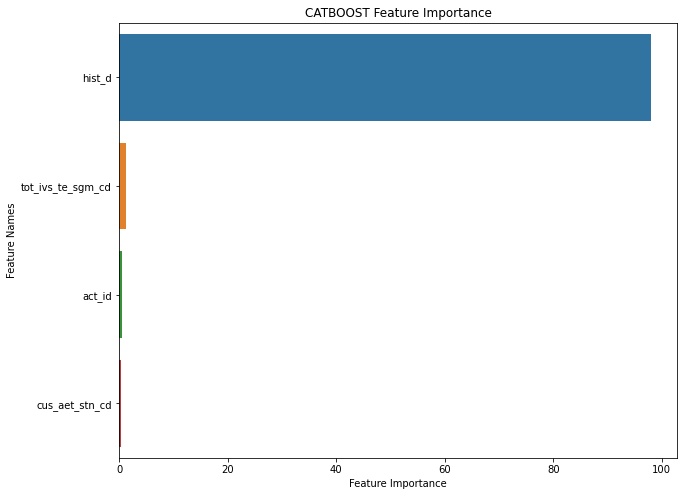

In [57]:
plot_feature_importance(cb_model.get_feature_importance(),tmp_val_x[['hist_d', 'act_id','tot_ivs_te_sgm_cd','cus_aet_stn_cd']].columns,'CATBOOST')

In [24]:
aaa =train_data.columns

In [35]:
tmp_train_x

,hist_d,act_id,tot_ivs_te_sgm_cd,cus_aet_stn_cd
0,283,399,5,2
1,187,399,5,2
2,344,7085,6,3
3,130,2074,5,5
4,27,2074,5,5
...,...,...,...,...
14393,5,7012,3,6
14394,2,7012,3,6
14395,1,3022,5,2
14396,7,3310,5,5


In [202]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

tmp_train_x1 = train_data_t1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
tmp_val_x1 =train_data_v1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

train_x1, val_x1, train_y1, val_y1 = train_test_split(tmp_train_x1, train_label1, test_size=0.2, random_state=777, shuffle=True)


#tmp_train_x = train_x[train_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]
#tmp_val_x = val_x[val_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]

# tmp_train_x = train_data_t[train_data_t.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]
# tmp_val_x = train_data_v[train_data_v.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]

#tmp_train_x1 = train_data_t1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
#tmp_val_x1 =train_data_v1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

model = XGBRegressor(missing= -1, enable_categorical=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)


model.fit(train_x1, train_y1,
          eval_set=[(val_x1, val_y1)],
          eval_metric=["rmse"],
          early_stopping_rounds=200, verbose=False)

preds2 = model.predict(tmp_val_x1)

rmse222 = np.sqrt(mean_squared_error(val_label1, preds2))
print(rmse222)
rmse222 = np.sqrt(mean_squared_error(val_label1*1.1, preds2))
print(rmse222)

[23:53:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


28.540647902910692
31.38760361006799


In [203]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

tmp_train_x2 = train_data_t2[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
tmp_val_x2 =train_data_v2[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

train_x2, val_x2, train_y2, val_y2 = train_test_split(tmp_train_x2, train_label2, test_size=0.2, random_state=777, shuffle=True)


#tmp_train_x = train_x[train_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]
#tmp_val_x = val_x[val_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]

# tmp_train_x = train_data_t[train_data_t.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]
# tmp_val_x = train_data_v[train_data_v.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]

#tmp_train_x1 = train_data_t1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
#tmp_val_x1 =train_data_v1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

model = XGBRegressor(missing= -1, enable_categorical=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)


model.fit(train_x2, train_y2,
          eval_set=[(val_x2, val_y2)],
          eval_metric=["rmse"],
          early_stopping_rounds=200, verbose=False)

preds2 = model.predict(tmp_val_x2)

rmse222 = np.sqrt(mean_squared_error(val_label2, preds2))
print(rmse222)
rmse222 = np.sqrt(mean_squared_error(val_label2*1.1, preds2))
print(rmse222)

[23:53:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


37.2503652077964
40.425835532920374


In [204]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

tmp_train_x3 = train_data_t3[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
tmp_val_x3 =train_data_v3[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

train_x3, val_x3, train_y3, val_y3 = train_test_split(tmp_train_x3, train_label3, test_size=0.2, random_state=777, shuffle=True)


#tmp_train_x = train_x[train_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]
#tmp_val_x = val_x[val_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]

# tmp_train_x = train_data_t[train_data_t.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]
# tmp_val_x = train_data_v[train_data_v.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]

#tmp_train_x1 = train_data_t1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
#tmp_val_x1 =train_data_v1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

model = XGBRegressor(missing= -1, enable_categorical=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)


model.fit(train_x3, train_y3,
          eval_set=[(val_x3, val_y3)],
          eval_metric=["rmse"],
          early_stopping_rounds=200, verbose=False)

preds2 = model.predict(tmp_val_x3)

rmse222 = np.sqrt(mean_squared_error(val_label3, preds2))
print(rmse222)
rmse222 = np.sqrt(mean_squared_error(val_label3*1.1, preds2))
print(rmse222)

[23:53:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


41.35134812593484
45.95963306553322


In [205]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

tmp_train_x4 = train_data_t4[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
tmp_val_x4 =train_data_v4[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

train_x4, val_x4, train_y4, val_y4 = train_test_split(tmp_train_x4, train_label4, test_size=0.2, random_state=777, shuffle=True)


#tmp_train_x = train_x[train_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]
#tmp_val_x = val_x[val_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]

# tmp_train_x = train_data_t[train_data_t.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]
# tmp_val_x = train_data_v[train_data_v.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]

#tmp_train_x1 = train_data_t1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
#tmp_val_x1 =train_data_v1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

model = XGBRegressor(missing= -1, enable_categorical=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)


model.fit(train_x4, train_y4,
          eval_set=[(val_x4, val_y4)],
          eval_metric=["rmse"],
          early_stopping_rounds=200, verbose=False)

preds2 = model.predict(tmp_val_x4)

rmse222 = np.sqrt(mean_squared_error(val_label4, preds2))
print(rmse222)
rmse222 = np.sqrt(mean_squared_error(val_label4*1.1, preds2))
print(rmse222)

[23:54:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:54:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


43.01223661314053
49.07369701403381


In [206]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

tmp_train_x5 = train_data_t5[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
tmp_val_x5 =train_data_v5[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

train_x5, val_x5, train_y5, val_y5 = train_test_split(tmp_train_x5, train_label5, test_size=0.2, random_state=777, shuffle=True)


#tmp_train_x = train_x[train_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]
#tmp_val_x = val_x[val_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]

# tmp_train_x = train_data_t[train_data_t.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]
# tmp_val_x = train_data_v[train_data_v.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]

#tmp_train_x1 = train_data_t1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
#tmp_val_x1 =train_data_v1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

model = XGBRegressor(missing= -1, enable_categorical=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)


model.fit(train_x5, train_y5,
          eval_set=[(val_x5, val_y5)],
          eval_metric=["rmse"],
          early_stopping_rounds=200, verbose=False)

preds2 = model.predict(tmp_val_x5)

rmse222 = np.sqrt(mean_squared_error(val_label5, preds2))
print(rmse222)
rmse222 = np.sqrt(mean_squared_error(val_label5*1.1, preds2))
print(rmse222)

[23:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


44.316886419464915
54.87876840528791


In [208]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

tmp_train_x6 = train_data_t6[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
tmp_val_x6 =train_data_v6[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

train_x6, val_x6, train_y6, val_y6 = train_test_split(tmp_train_x6, train_label6, test_size=0.2, random_state=777, shuffle=True)


#tmp_train_x = train_x[train_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]
#tmp_val_x = val_x[val_x.columns.difference(['iem_krl_nm', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd'])]

# tmp_train_x = train_data_t[train_data_t.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]
# tmp_val_x = train_data_v[train_data_v.columns.difference(['iem_krl_nm','ivs_icn_cd','tco_cus_grd_cd'])]

#tmp_train_x1 = train_data_t1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]
#tmp_val_x1 =train_data_v1[['hist_d', 'tot_ivs_te_sgm_cd','cus_aet_stn_cd','change']]

model = XGBRegressor(missing= -1, enable_categorical=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)


model.fit(train_x6, train_y6,
          eval_set=[(val_x6, val_y6)],
          eval_metric=["rmse"],
          early_stopping_rounds=200, verbose=False)

preds2 = model.predict(tmp_val_x6)

rmse222 = np.sqrt(mean_squared_error(val_label6, preds2))
print(rmse222)
rmse222 = np.sqrt(mean_squared_error(val_label6*1.1, preds2))
print(rmse222)

[23:54:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:54:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


46.408291969717766
67.35300718513858


In [210]:
print((46+44+43+28+37+41)/6)

39.833333333333336


In [ ]:
'sex_dit_cd', 'cus_aet_stn_cd', 'tco_cus_grd_cd', 'bnc_qty', 'tot_aet_amt', 'ivs_icn_cd'

In [104]:
train_data_t

,act_id,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,change
0,399,283,1,9,3.0,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0,4
1,399,187,1,9,3.0,2,2,9,5,5,8,1884,13,1,2,305.0,9973500.0,500.0,32700.0,11
2,7085,344,1,6,NaN,3,2,5,5,6,9,973,10,2,2,102.0,507450.0,500.0,4975.0,25
3,2074,130,1,4,5.0,5,2,3,4,5,16,883,7,3,99,1670.0,9769500.0,5000.0,5850.0,56
4,2074,27,1,4,5.0,5,2,3,4,5,16,2663,13,3,99,7999.0,19517560.0,500.0,2440.0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14393,7012,5,2,2,NaN,6,2,2,2,3,16,1851,10,1,2,264.0,34584000.0,500.0,131000.0,2
14394,7012,2,2,2,NaN,6,2,2,2,3,16,2858,12,2,1,208.0,10015200.0,500.0,48150.0,2
14395,3022,1,1,7,3.0,2,2,5,5,5,10,470,13,3,99,3523.0,4756050.0,100.0,1350.0,2
14396,3310,7,1,6,NaN,5,2,5,3,5,2,1501,10,2,99,10.0,33950.0,100.0,3395.0,49


In [124]:
train_data_t = train_data_t.sort_values(by='hist_d')

In [164]:
train_data_t1 = train_data_t[train_data_t['hist_d']<=10]
train_data_t2 = train_data_t[(train_data_t['hist_d']>10) & (train_data_t['hist_d']<=50)]
train_data_t3 = train_data_t[(train_data_t['hist_d']>50) & (train_data_t['hist_d']<=100)]
train_data_t4 = train_data_t[(train_data_t['hist_d']>100) & (train_data_t['hist_d']<=200)]
train_data_t5 = train_data_t[(train_data_t['hist_d']>200) & (train_data_t['hist_d']<=300)]
train_data_t6 = train_data_t[(train_data_t['hist_d']>300)]

In [165]:
train_data_v1 = train_data_v[train_data_v['hist_d']<=10]
train_data_v2 = train_data_v[(train_data_v['hist_d']>10) & (train_data_v['hist_d']<=50)]
train_data_v3 = train_data_v[(train_data_v['hist_d']>50) & (train_data_v['hist_d']<=100)]
train_data_v4 = train_data_v[(train_data_v['hist_d']>100) & (train_data_v['hist_d']<=200)]
train_data_v5 = train_data_v[(train_data_v['hist_d']>200) & (train_data_v['hist_d']<=300)]
train_data_v6 = train_data_v[(train_data_v['hist_d']>300)] 

In [ ]:
train_data_v1 = train_data_v[train_data_v['hist_d']<=10]
train_data_v2 = train_data_v[(train_data_v['hist_d']>10) & (train_data_v['hist_d']<=50)]
train_data_v3 = train_data_v[(train_data_v['hist_d']>50) & (train_data_v['hist_d']<=100)]
train_data_v4 = train_data_v[(train_data_v['hist_d']>100) & (train_data_v['hist_d']<=200)]
train_data_v5 = train_data_v[(train_data_v['hist_d']>200) & (train_data_v['hist_d']<=300)]
train_data_v6 = train_data_v[(train_data_v['hist_d']>300)] 

In [211]:
test_data

,act_id,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,change
0,399,153,1,9,3.0,2,2,9,5.0,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0,1
1,399,335,1,9,3.0,2,2,9,5.0,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0,2
2,399,139,1,9,3.0,2,2,9,5.0,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0,3
3,399,236,1,9,3.0,2,2,9,5.0,5,8,2681,13,3,99,2972.0,6716720.0,500.0,2260.0,4
4,399,9,1,9,3.0,2,2,9,5.0,5,8,2450,13,1,2,10.0,464500.0,100.0,46450.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,3310,23,1,6,NaN,5,2,5,3.0,5,2,1369,2,1,1,1.0,198500.0,500.0,198500.0,6
70592,3310,103,1,6,NaN,5,2,5,3.0,5,2,444,2,99,99,50.0,372000.0,5000.0,7440.0,9
70593,2678,858,1,4,4.0,2,2,3,4.0,3,8,1280,14,3,99,75057.0,3677793.0,100.0,49.0,1
70594,2678,11,1,4,4.0,2,2,3,4.0,3,8,2373,8,2,99,96.0,11424000.0,2500.0,119000.0,6


In [166]:
train_label1 = train_data_t1["hold_d"]
train_data_t1.drop(["hold_d"], axis = 1, inplace = True)
train_label2 = train_data_t2["hold_d"]
train_data_t2.drop(["hold_d"], axis = 1, inplace = True)
train_label3 = train_data_t3["hold_d"]
train_data_t3.drop(["hold_d"], axis = 1, inplace = True)
train_label4 = train_data_t4["hold_d"]
train_data_t4.drop(["hold_d"], axis = 1, inplace = True)
train_label5 = train_data_t5["hold_d"]
train_data_t5.drop(["hold_d"], axis = 1, inplace = True)
train_label6 = train_data_t6["hold_d"]
train_data_t6.drop(["hold_d"], axis = 1, inplace = True)


C:\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [167]:

val_label1 = train_data_v1["hold_d"]
train_data_v1.drop(["hold_d"], axis = 1, inplace = True)
val_label2 = train_data_v2["hold_d"]
train_data_v2.drop(["hold_d"], axis = 1, inplace = True)
val_label3 = train_data_v3["hold_d"]
train_data_v3.drop(["hold_d"], axis = 1, inplace = True)
val_label4 = train_data_v4["hold_d"]
train_data_v4.drop(["hold_d"], axis = 1, inplace = True)
val_label5 = train_data_v5["hold_d"]
train_data_v5.drop(["hold_d"], axis = 1, inplace = True)
val_label6 = train_data_v6["hold_d"]
train_data_v6.drop(["hold_d"], axis = 1, inplace = True)


In [126]:
for i in range (14398):
    if train_data_t.loc[i,'hist_d'] < 50:
        q= q +1
    elif train_data_t.loc[i,'hist_d'] < 100:
        w = w +1        
    elif train_data_t.loc[i,'hist_d'] < 200:
        e= e +1    
    elif train_data_t.loc[i,'hist_d'] < 300:
        r= r +1        
    elif train_data_t.loc[i,'hist_d'] < 400:
        k= k +1        
    else:
        j= j +1 
        

In [213]:
test = pd.read_csv("stk_hld_test.csv")
test

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0
...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0


In [214]:
test_data['submit_id'] = test['submit_id']

In [217]:
test_data3 =test_data 

In [99]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

train_data1 = train_data[train_data.columns.difference(['tco_cus_grd_cd','ivs_icn_cd'])]
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose = False)

grid.fit(train_data1, train_label)
#print(grid.best_params_)


UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

In [ ]:
print(grid_search.best_params_)

{'colsample_bylevel': 1, 'colsample_bytree': 1, 'max_depth': 3, 'n_estimators': 300}


In [ ]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [31]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

train_data1 = train_data[train_data.columns.difference(['sex_dit_cd', 'cus_aet_stn_cd', 'tco_cus_grd_cd', 'bnc_qty', 'tot_aet_amt', 'ivs_icn_cd'])]


grid_search = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=-1, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


grid_search.fit(train_data1, train_label)



[17:31:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=-1, monotone_constraints='()',
             n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=0, silent=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [343]:
test_data1 = test_data[['hist_d', 'act_id','tot_ivs_te_sgm_cd','cus_aet_stn_cd']]
y_pred = cb_model.predict(test_data1)
submission["hold_d"] = np.round(y_pred)

<ipython-input-343-75cc21b46bb2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["hold_d"] = np.round(submission["hold_d"])


,submit_id,hold_d
0,IDX00001,221.0
1,IDX00002,400.0
2,IDX00003,219.0
3,IDX00004,278.0
4,IDX00005,29.0
...,...,...
70591,IDX70592,58.0
70592,IDX70593,161.0
70593,IDX70594,1073.0
70594,IDX70595,39.0


In [96]:
test_data1 = test_data1.assign(hold=y_pred)

In [97]:
test_data1['hold'] = test_data1['hold']*1.1

In [98]:
def plus10(x):
    if (x["hold"] - x["hist_d"]) >= 146:
        return x["hist_d"] + 146
    else:
        return x["hold"]

In [99]:
test_data1["hold"] = test_data1.apply(plus10, axis =1)

In [100]:
print(test_data1["hold"])

0        220.550897
1        404.860491
2        201.474165
3        296.679839
4         37.308797
            ...    
70591     61.840997
70592    160.144669
70593    620.347964
70594     40.974382
70595     28.652606
Name: hold, Length: 70596, dtype: float64


In [101]:
submission["hold_d"] = np.round(test_data1["hold"])

In [ ]:
result = [] #k fold
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)

NameError: ignored

In [70]:
submission["hold_d"] = np.round(predict)

NameError: name 'predict' is not defined

In [ ]:
#공통

In [408]:
submission.to_csv("dacon_baseline1.13.csv", index = False)